In [325]:
library(dplyr)
library(tidyr)
library(tibble)
library(xtable)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)

theme_set(theme_bw())

In [340]:
source("R/calc.R")
source("R/misc.R")
source("R/normalise.R")
source("R/plot.R")
source("R/predict.R")
source("R/subset.R")
source("R/utils.R")

## Import data

In [9]:
# Metadata
METADATA_SID <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [10]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
metadata_pid$label <- as.factor(metadata_pid$label)

# Scale -> Remove -> Filter -> Log
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### D33

In [240]:
path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
metadata_d33 <- read.table(path2, sep = "\t", header = T)

In [246]:
metadata_d33[] <- lapply(metadata_d33, as.factor)
metadata_d33$class_info <- factor(
  metadata_d33$class_info,
  levels = c("D0", "D8", "D33", "N")
)

yeoh_d33_allps <- log2_transform(normaliseMeanScaling(yeoh_d33))
# Remove samples that have been curated out of data set
# Members that have been curated out are no longer in metadata_d33
missing_samples <- colnames(yeoh_d33_allps)[
  !(colnames(yeoh_d33_allps) %in% rownames(metadata_d33))]
# Remove patients from D33 that have been curated out
yeoh_d33 <- yeoh_d33_allps[
  rownames(yeoh),
  !(colnames(yeoh_d33_allps) %in% missing_samples)
]

P001_D33 P007_D33 P008_D33 P009_D33 P010_D33 P013_D33 
61.89674 59.89209 63.48604 57.78878 60.81653 60.31188 


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [13]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch features

Constant: Timepoint, subtype , remission

In [14]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

### Drug genes

Constant: Subtype, remission

### M1: Entire data

In [20]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps
)
names(list_obj) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
No. of remission samples in training set = 31
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 487
No. of features (p-value) 

#### Plot by treatment

In [21]:
list_X_y <- lapply(list_obj, function(obj) {
  cbind(obj$X_y, metadata_pid[rownames(obj$X_y), "treatment", drop = FALSE])
})
boxplots <- lapply(
  list_X_y, plot_boxplots_v2,
  colour_by = "treatment", shape_by = "label"
)

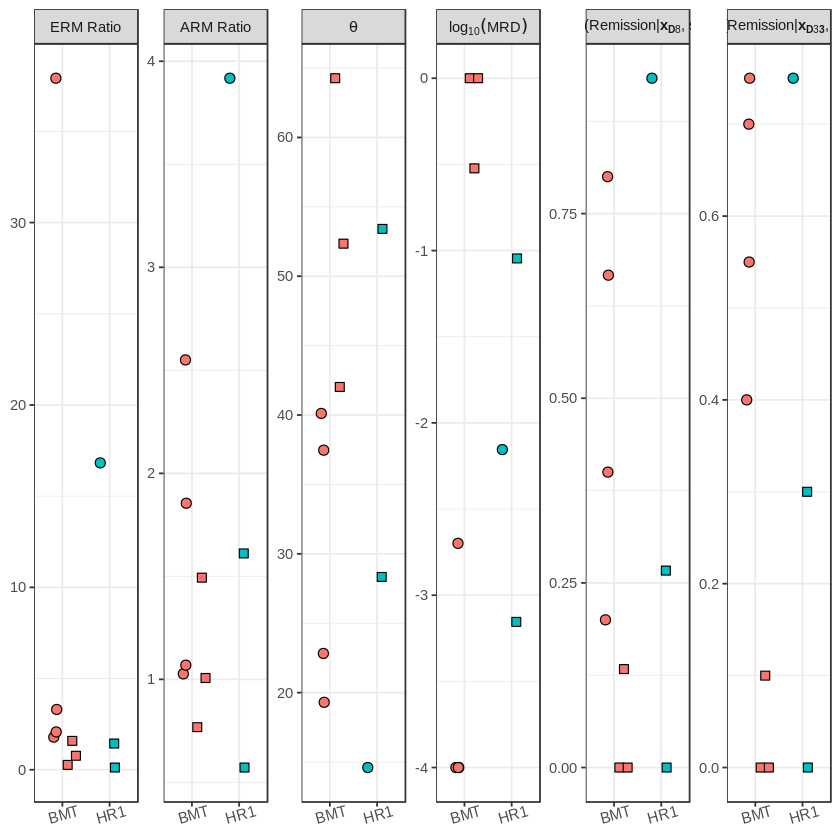

In [22]:
plot_boxplots_v2(list_X_y[[1]], colour_by = "treatment", shape_by = "label")

#### Save predicted probas

In [355]:
# all_probas_d8 <- lapply(unname(list_obj1), function(obj) obj$X_y["p_d8"])
# all_p_d8 <- do.call(rbind, all_probas_d8)
# write.table(all_p_d8, "tmp/all_p_d8.tsv", quote = F, sep = "\t")

In [356]:
# all_probas_d33 <- lapply(unname(list_obj1), function(obj) obj$X_y["p_d33"])
# all_p_d33 <- do.call(rbind, all_probas_d33)
# write.table(all_p_d33, "tmp/all_p_d33.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline_v2,
#   X_normal, metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

In [98]:
# boxplots <- lapply(list_obj1, function(obj) plot_boxplots(obj$X_y))

# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_alltrain_simulated-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

In [99]:
# for (i in seq_len(length(subtypes7))) {
#   wpath <- sprintf("~/Dropbox/tmp/features_treatment-%s.pdf", subtypes7[i])
#   ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
# }

## Investigate: Feature values

In [368]:
features <- c("erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal", "log_mrd_d33")
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  features = features,
  direction = c("<", "<", ">", ">")
)
names(list_obj) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 164
No. of samples in centroid = 5
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 216
No. of samples in centroid = 31
No. of remission samples in training set = 31
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 487
No. of features (p-value) 

In [369]:
list_X_y <- lapply(list_obj, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplots, features = features)

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message 

In [370]:
for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/features-%s.pdf", subtypes7[i])
  ggsave(wpath, boxplots[[i]], width = 9, height = 2.5)
}

In [371]:
list_p_d8 <- lapply(list_obj, function(obj) obj$X_y["p_d8"])
p_d8 <- do.call(rbind, unname(list_p_d8))
write.table(p_d8, "tmp/original-p_d8.tsv", quote = F, sep = "\t")

In [372]:
list_p_d33 <- lapply(list_obj, function(obj) obj$X_y["p_d33"])
p_d33 <- do.call(rbind, unname(list_p_d33))
write.table(p_d33, "tmp/original-p_d33.tsv", quote = F, sep = "\t")

### Plotting: New features

In [ ]:
list_features <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  return_features = TRUE
)
names(list_features) <- subtypes7

In [320]:
angles <- c(
  "angle_LD0_LD8", "angle_LD0_LN", "angle_LD8_LN",
  "angle_d0d8_d0normal", "angle_d0_d8", "angle_d8_normal",
  "erm1_ratio2", "l2norm_ratio2"
)
list_angles <- list_features %>%
  lapply(subset, select = angles) %>%
  lapply(rownames_to_column)

subtypes3 <- c("BCR-ABL", "T-ALL", "TEL-AML1")
data_angles <- list_angles %>%
  bind_rows(.id = "subtype") %>%
  cbind(label = metadata_pid[.$rowname, "label"]) %>%
  subset(subtype %in% subtypes3)

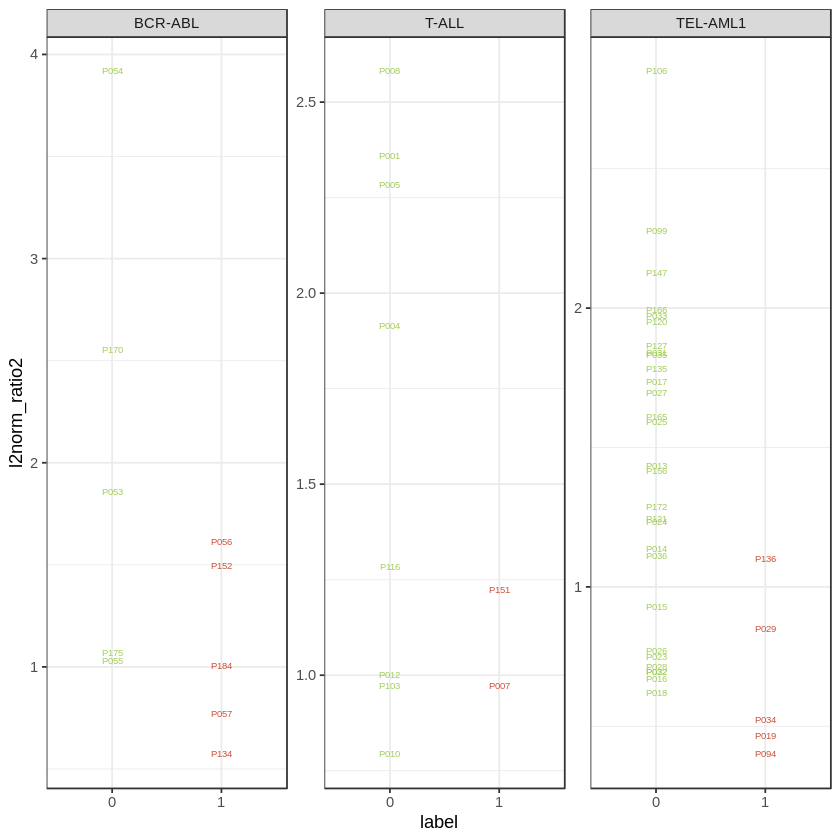

In [323]:
# Features vs label
ax <- ggplot(
  data_angles,
  aes(
    x = label, y = l2norm_ratio2,
    color = label, label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
  geom_text(cex = 2, show.legend = FALSE) +
  scale_color_manual(values = COL_LABEL)

ax

ggsave("~/Dropbox/tmp/arm.pdf", ax, width = 5, height = 3)

In [81]:
# Feature vs feature

# Treatment progression v.s. remaining deviation
ax <- ggplot(
  data_angles,
  aes(
    x = angle_LD0_LN, y = angle_LD0_LD8 / angle_LD0_LN,
    color = label, label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
  geom_text(cex = 2, show.legend = FALSE) +
  scale_color_manual(values = COL_LABEL)

ggsave("~/Dropbox/tmp/angle1.pdf", ax, width = 5, height = 3)

# Treatment progression (diff) v.s. remaining deviation
ax <- ggplot(
  data_angles,
  aes(
    x = angle_LD0_LN, y = (angle_LD0_LN - angle_LD8_LN) / angle_LD0_LN,
    color = label, label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
  geom_text(cex = 2, show.legend = FALSE) +
  scale_color_manual(values = COL_LABEL)

ggsave("~/Dropbox/tmp/angle2.pdf", ax, width = 5, height = 3)

In [313]:
# TODO: Why is it not equal?
# Treatment progression (diff) v.s. remaining deviation
ax <- ggplot(
  data_angles,
  aes(
    x = angle_LD8_LN, y = angle_LD0_LD8,
    color = label, label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
  geom_text(cex = 2, show.legend = FALSE) +
  scale_color_manual(values = COL_LABEL)

ggsave("~/Dropbox/tmp/angle-vs1.pdf", ax, width = 5, height = 3)

## Investigate: Specific patient IDs

In [82]:
FILE1 <- "tmp/pid_relapse_srir-d8.txt"
FILE2 <- "tmp/pid_relapse_srir-d33.txt"
pid_relapse_d8 <- sort(readLines(FILE1))
pid_relapse_d33 <- sort(readLines(FILE2))

In [83]:
p_d8 <- read.table("tmp/p_d8.tsv", sep = "\t")
p_d33 <- read.table("tmp/p_d33.tsv", sep = "\t")
p_tp2 <- read.table("tmp/p_tp2.tsv", sep = "\t")

In [84]:
p_d8[pid_relapse_d8, , drop = F]
p_d33[pid_relapse_d33, , drop = F]

,p_d8
,<dbl>
P029,0.2528736
P056,0.2666667
P136,0.2988506
P151,0.4166667


,p_d33
,<dbl>
P007,0.2812500
P034,0.3017241
P056,0.3000000
P094,0.2672414
P136,0.4741379
P151,0.3750000


#### Relapse patients with good ERM
- Only in subtypes BCR-ABL, T-ALL, TEL-AML1

In [191]:
features <- c(
  "erm1", "l2norm_d0_d8", "erm1_ratio2",
  "l2norm_ratio2", "angle_d0d8_d0normal", "log_mrd_d33"
)
list_V_fltr <- lapply(list_V, subset, select = features)
V_fltr <- bind_rows(lapply(list_V_fltr, rownames_to_column), .id = "subtype")
V_fltr <- cbind(
  V_fltr,
  label = metadata_pid[V_fltr$rowname, "label"]
)

V1 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

### Investigate patients with discrepancy between features

In [220]:
# Difference in rank / total number
# Rank three features. Rank of 1 means it is more likely to achieve remission
list_ranks <- lapply(
  list_V_fltr,
  function(X) data.frame(
    erm = rank(-X$erm1),
    arm = rank(-X$l2norm_d0_d8),
    theta = rank(X$angle_d0d8_d0normal),
    row.names = rownames(X)
  )
)

list_rankdiff <- lapply(
  list_ranks,
  function(X) {
    x <- abs((X$erm - X$theta) / nrow(X))
    names(x) <- rownames(X)
    x
  }
)

rankdiffs <- do.call(c, unname(list_rankdiff))
# hist(rankdiffs, breaks = 20)

THRESHOLD <- 0.2
pid_discrepancy <- names(rankdiffs)[rankdiffs > THRESHOLD]

# Investigating patients with discrepancy between features
y1 <- metadata_pid[pid_discrepancy, c("subtype", "label")] %>%
  subset(!(subtype %in% c("Hyperdiploid", "Others")))

p_d8[rownames(y1), , drop = FALSE]

,p_d8
,<dbl>
P152,0.1333333
P051,0.6666667
P004,0.6250000
P007,0.2500000
P010,0.1250000
P012,0.3750000
P120,0.8045977
P135,0.7126437


In [222]:
# Difference in rank / total number
# Rank three features. Rank of 1 means it is more likely to achieve remission
list_ranks <- lapply(
  list_V_fltr,
  function(X) data.frame(
    erm = rank(-X$erm1),
    arm = rank(-X$l2norm_d0_d8),
    theta = rank(X$angle_d0d8_d0normal),
    row.names = rownames(X)
  )
)

list_rankdiff <- lapply(
  list_ranks,
  function(X) {
    x <- abs((X$arm - X$theta) / nrow(X))
    names(x) <- rownames(X)
    x
  }
)

rankdiffs <- do.call(c, unname(list_rankdiff))
# hist(rankdiffs, breaks = 20)

THRESHOLD <- 0.4
pid_discrepancy <- names(rankdiffs)[rankdiffs > THRESHOLD]

# Investigating patients with discrepancy between features
y1 <- metadata_pid[pid_discrepancy, c("subtype", "label")] %>%
  subset(!(subtype %in% c("Hyperdiploid", "Others")))

p_d8[rownames(y1), , drop = FALSE]

,p_d8
,<dbl>
P057,0.0000000
P184,0.0000000
P051,0.6666667
P145,0.4000000
P160,0.7777778
P167,0.0000000
P004,0.6250000
P010,0.1250000


In [194]:
V2 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "E2A-PBX1", "T-ALL", "MLL", "TEL-AML1"))
V3 <-  filter(V_fltr, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

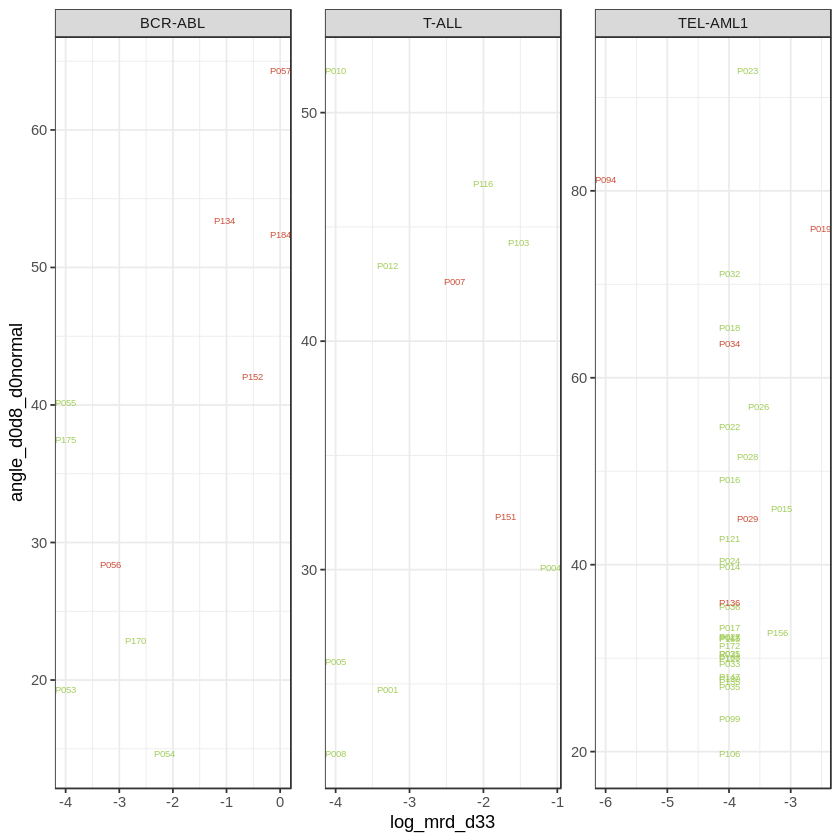

In [196]:
ax <- ggplot(
  V2,
  aes(
    x = l2norm_d0_d8, y = angle_d0d8_d0normal,
    color = label, fill = label,
    label = rowname
  )
) +
  facet_wrap(~subtype, nrow = 1, scales = "free") +
#   geom_point(
#     position = position_jitterdodge(),
#     pch = 21, cex = 2, show.legend = FALSE
#   ) +
  geom_text(
    cex = 2, show.legend = FALSE
  ) +
  scale_fill_manual(values = COL_LABEL) +
  scale_color_manual(values = COL_LABEL)

ax

ggsave("~/Dropbox/tmp/MRD.pdf", ax, width = 7, height = 5)

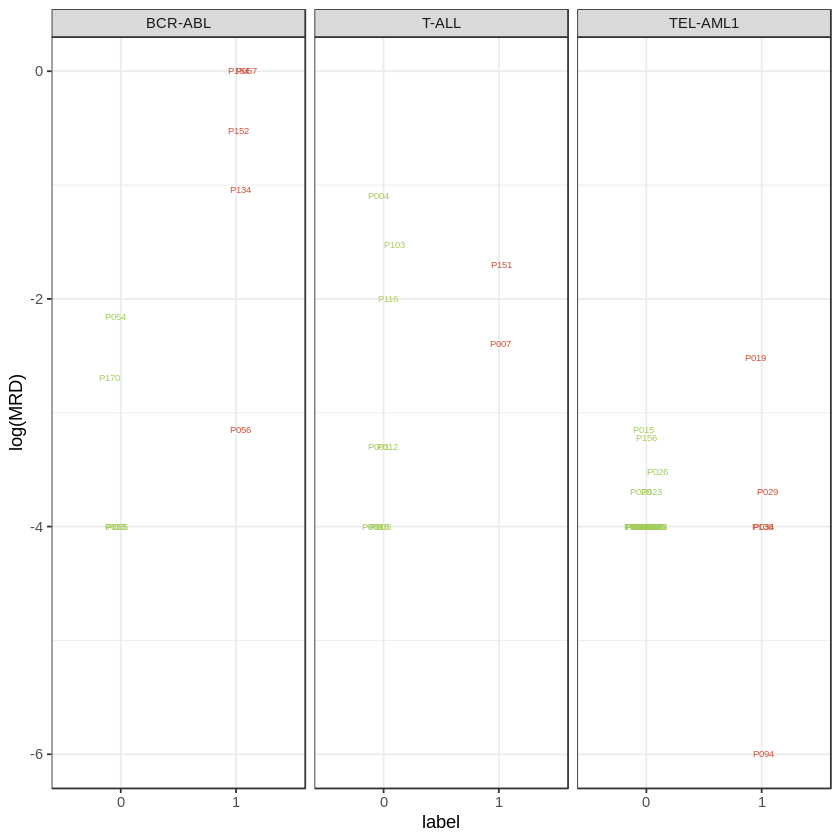

In [205]:
ax <- ggplot(
  V3,
  aes(
    x = label, y = log_mrd_d33,
    color = label, fill = label, label = rowname)
) +
  facet_wrap(~subtype) +
  geom_text(
    position = position_jitterdodge(),
    cex = 2, show.legend = FALSE
  ) +
  scale_color_manual(values = COL_LABEL) +
  labs(y = "log(MRD)")

ax

ggsave("~/Dropbox/tmp/log_mrd.pdf", ax, width = 5, height = 2.5)

#### Individual features

In [38]:
list_X_y <- lapply(
  list_obj1,
  function(obj) rownames_to_column(obj$X_y)
)
X_y <- bind_rows(list_X_y, .id = "subtype")
X_y_sub <-  filter(X_y, subtype %in% c("BCR-ABL", "T-ALL", "TEL-AML1"))

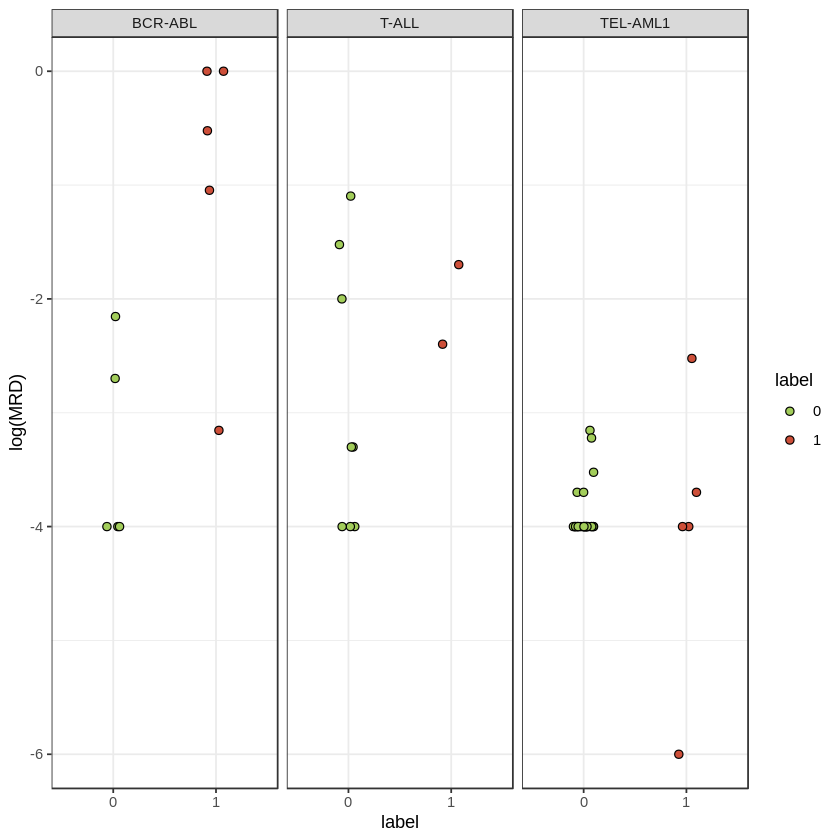

In [40]:
ax <- ggplot(
  X_y_sub,
  aes(x = label, y = log_mrd_d33, fill = label)
) +
  facet_wrap(~subtype) +
  geom_point(position = position_jitterdodge(), pch = 21, cex = 2) +
  scale_fill_manual(values = COL_LABEL) +
  labs(y = "log(MRD)")
ax

# ggsave("~/Dropbox/tmp/log_mrd.pdf", ax, width = 5, height = 2.5)

In [69]:
# Load relapse patients predicted as SR/IR
file <- "tmp/pid_relapse_srir.txt"
pid <- readLines(file)
X_y[pid,]

,subtype,erm1_ratio2,l2norm_ratio2,angle_d0d8_d0normal,log_mrd_d33,p_d8,p_d33,label
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
P056,BCR-ABL,1.43645701,1.6113608,28.33446,-3.154902,0.26666667,0.3000000,1
P007,T-ALL,0.75701293,0.9710019,42.59169,-2.397940,0.25000000,0.2812500,1
P151,T-ALL,1.15021746,1.2218995,32.29299,-1.698970,0.41666667,0.3750000,1
P034,TEL-AML1,0.17666919,0.5215379,63.57314,-4.000000,0.06896552,0.3017241,1
P094,TEL-AML1,0.02149864,0.3998272,81.18984,-6.000000,0.02298851,0.2672414,1
P136,TEL-AML1,0.81113048,1.1008967,35.89147,-4.000000,0.29885057,0.4741379,1


### Identify patients with clonal evolution

Relapse patients that show good MRD. Investigating D33 samples

In [270]:
metadata_clonal <- metadata_pid %>%
  subset(
    label == 1 & d33_mrd < 0.01 & subtype == "TEL-AML1",
    select = c(d33_mrd, wk12_mrd, subtype)
  )

# Only TEL-AML1 has >2 samples
pid_telaml1_1 <- rownames(metadata_clonal) %>%
  intersect(substring(colnames(yeoh_d33), 1, 4))
sid_telaml1_1 <- paste0(pid_telaml1_1, "_D33")

In [271]:
pid_telaml1_0 <- metadata_pid %>%
  subset(subtype == "TEL-AML1" & label == 0) %>%
  rownames() %>%
  intersect(substring(colnames(yeoh_d33), 1, 4))
sid_telaml1_0 <- paste0(pid_telaml1_0, "_D33")

In [295]:
# DE probesets
telaml1_0 <- yeoh_d33[, sid_telaml1_0]
telaml1_1 <- yeoh_d33[, sid_telaml1_1]

pvalues <- calc_univariate(t.test, telaml1_0, telaml1_1)
ALPHA <- 0.05
ps_ttest <- rownames(yeoh_d33)[pvalues < ALPHA & !is.na(pvalues)]

logfc <- calc_logfc(telaml1_0, telaml1_1)
ps_logfc <- rownames(yeoh_d33)[logfc > .5]
ps_diff <- intersect(ps_ttest, ps_logfc)

# Sample IDs
pid_telaml1 <- c(pid_telaml1_0, pid_telaml1_1)
sid_telaml1 <- paste0(rep(pid_telaml1, each = 3), c("_D0", "_D8", "_D33"))

In [296]:
concat_metadata <- function(ps_diff) {
  telaml1 <- cbind(yeoh, yeoh_d33)[ps_diff, sid_telaml1] %>%
    rownames_to_column() %>%
    gather(key = sid, value = value, -rowname)
  X_y <- cbind(
    metadata_d33[telaml1$sid, c("class_info", "label")],
    pid = substring(telaml1$sid, 1, 4),
    telaml1
  )
  X_y
}

In [297]:
telaml1 <- concat_metadata(ps_diff)

In [309]:
ps_ttest <- substring(names(sort(pvalues)), 2)

In [311]:
telaml1 <- concat_metadata(ps_ttest[1:10])

In [312]:
# Plot out
ax <- ggplot(
  telaml1,
  aes(x = class_info, y = value, group = pid, col = label)
) +
  facet_grid(label ~ rowname) +
  scale_color_manual(values = COL_LABEL) +
  geom_line()

ggsave("~/Dropbox/tmp/evolution_ps1.pdf", ax, width = 9, height = 3)

In [ ]:
# TO-DO

## D8-D33

In [123]:
#' Identifies (treatment response genes - batch genes) from D0, D8 samples
get_local_genes_pipeline <- function(
  X_subtype, X_normal,
  metadata, metadata_mrd,
  batch_genes = NULL
) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0 ]
  
  getLocalGenes(X_subtype, sid_remission)
}

In [124]:
X_normal <- data[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) data[,
    sid_alltrain_local[Y[sid_alltrain_local, "subtype"] == subtype]
  ]
)
list_genes <- lapply(
  list_X_subtypes7,
  get_local_genes_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)
names(list_genes) <- subtypes7

            P053_D0   P054_D0  P055_D0   P056_D0   P057_D0  P134_D0  P152_D0
1053_at    8.691204  7.602195 9.411247  9.242660  8.934701 8.410668 8.619703
117_at     0.000000  0.000000 6.464115  0.000000  0.000000 5.075805 6.705585
121_at     8.328702  8.478739 8.136448  7.723151  9.359687 7.378248 8.212045
1294_at   10.884327 11.614881 9.441801 10.270406 11.136562 9.740906 9.956232
1316_at    8.276770  7.841803 5.060726  5.470828  6.801432 8.122399 6.352926
160020_at  0.000000  0.000000 0.000000  6.864270  0.000000 7.158413 7.363750
           P170_D0   P175_D0   P184_D0   P053_D8   P054_D8  P055_D8  P056_D8
1053_at   8.900116  9.169554  9.409609  8.467285  8.381870 8.580089 7.638956
117_at    7.109241  5.982598  0.000000  0.000000  6.083772 7.263181 7.605420
121_at    8.248110  8.299106  8.345388  8.260321  8.702202 7.735235 7.625789
1294_at   9.055452 10.253467 10.323843 10.895341 10.210585 9.240541 9.190876
1316_at   7.071496  8.029674  6.288424  9.315711  8.533834 5.141719 6.031292

In [188]:
# D0-D33 data set
pid_pairs <- substring(colnames(yeoh_d33), 1, 4)
# Not in hypodiploid or normal
# Has to have MRD value
pid_pairs_fltr <- pid_pairs[
  !(yeoh_label[pid_pairs, 'subtype'] %in% c('Hypodiploid', 'Normal', 'MLL')) &
  !is.na(yeoh_label[pid_pairs, 'd33_mrd'])
]

In [198]:
metadata_sid_pairs <- yeoh_label[pid_pairs_fltr, ]
print(xtable(table(metadata_sid_pairs$subtype, metadata_sid_pairs$label)))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Sep 10 02:43:10 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   1 &   1 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &   6 &   1 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   0 &   0 \\ 
  Others &  17 &   5 \\ 
  T-ALL &   3 &   1 \\ 
  TEL-AML1 &   9 &   3 \\ 
   \hline
\end{tabular}
\end{table}


In [201]:
sid_pairs <- c(
  paste0(pid_pairs_fltr, '_D8'),
  paste0(pid_pairs_fltr, '_D33')
)
d0_d33 <- cbind(data, yeoh_d33)[, sid_pairs]

In [202]:
#' ASSUMPTION: X_train is filtered of NA MRD values and contains all features!
#' @param X_train dataframe of training set (incl. MRD) with patients x features
#' @param Y dataframe of metadata with samples x info
#' @param bigpos_names vector of feature names where bigger is positive
#' @param smallpos_names vector of feature names where smaller is positive
#' @param X_test dataframe of test set (incl. MRD)
predict_plot_d8_d33 <- function(X_train, Y,
                         bigpos_names,
                         smallpos_names,
                         X_test = NULL) {  
  # If test set is present, predict test set
  if (is.null(X_test)) {
    X_predict <- X_train
  } else {
    X_predict <- X_test
  }
  
  p_remission_x <- calc_p_remission_x(
    X_train, Y,
    bigpos_names,
    smallpos_names,
    X_predict
  )
  proba <- p_remission_x # OPTION!
  
  # Select features
  X_fltr_train <- X_train[, c(bigpos_names, smallpos_names)]
  X_fltr_predict <- X_predict[, c(bigpos_names, smallpos_names)]
  
  # Select p(remission|x)
  p <- proba[, "p", drop = F] # OPTION!
  colnames(p) <- "p_rem"
  # Concatenate features and probabilities
  X_y <- cbind(
    X_fltr_predict,
    p,
    label = proba$label
  )
  
  X_y$mrd <- log10(X_y$mrd) # log-transform mrd
  colnames(X_y)[colnames(X_y) == "mrd"] <- "log_mrd"

  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
  
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_d0d8_d0normal", "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ')')"
  )
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  ) # Reorder levels

  ##### PLOTS #####
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    list_p_rem <- split(X_y$p_rem, X_y$label)
    
    try({
      ttest <- t.test(list_p_rem[[1]], list_p_rem[[2]])
      p_lab <- sprintf("p = %.3f", ttest$p.value)
      
      ann_text <- data.frame(
        feature = factor(
          FEAT_ORDER[5],
          levels = FEAT_ORDER,
          labels = FEAT_LABS
        ),
        value = Inf,
        lab =  p_lab
      )

      ax_jitter <- ax_jitter +
        geom_text(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  vjust = 3, hjust = -0.1)
      })
  }
  
  ## Plot: Parallel coordinates - Pct
  proba1 <- proba[, !(colnames(proba) == "p_wo_mrd")]
  long_proba <- melt(proba1, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_proba,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: CDF
  emp_cdf <- ggplot(proba, aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- proba[order(proba$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
  
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
  
  ## Plot: ROC
  # ERM1 evaluated is not from global GSS model
  proba_x <- cbind(proba, erm = X_predict$erm1, d33_mrd = X_predict$mrd) # subset mrd
                                
  x_names <- c("p", "erm", "d33_mrd")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (all(table(proba_x$label) != 0)) {
    ax_roc <- plot_roc(proba_x, "label", x_names)
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                     ncol = 2, rel_widths = c(1.8, 1))
  } else{
    ax2 <- ax_parallel # unable to plot ROC
  }
  
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(proba_x) +
    geom_point(aes(p, log10(d33_mrd), colour = label),
               cex = 3, show.legend = F) +
    scale_color_manual(values = COL_LABEL)
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)
  
  list(
    p_rem = p,
    P = proba,
    X_y = X_y,
    plot = fig
  )
}

In [204]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline_d8_d33 <- function(
  subtype, X, X_normal,
  annot, annot_mrd,
  batch_genes = NULL
) {
  X_subtype <- X[, annot[colnames(X), 'subtype'] == subtype]
  
  sid_remission <- colnames(X_subtype)[
    annot[colnames(X_subtype), "label"] == 0
  ]
  
  class_genes <- list_genes[[subtype]]
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- annot_mrd[rownames(V), "d33_mrd"]
  
  prediction_obj <- predict_plot_d8_d33(
    V, annot,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(V)
}

In [215]:
subtypes6 <- setdiff(subtypes7, 'MLL')
X_normal <- data[, sid_normal]

list_results <- lapply(
  subtypes6,
  predict_pipeline_d8_d33,
  d0_d33, X_normal, annot_all, yeoh_label,
  batch_genes
)
names(list_results) <- subtypes6

[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
[1] "P053_D8" "P057_D8"
[1] "NO. OF SAMPLES IN CENTROID: 1"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
[1] "P049_D8" "P050_D8" "P051_D8"
[1] "NO. OF SAMPLES IN CENTROID: 3"
[1] "No. of selected genes = " "281"                     
[1] "No. of final genes = " "216"                  
[1] "P037_D8" "P038_D8" "P039_D8" "P041_D8" "P043_D8" "P046_D8" "P048_D8"
[1] "NO. OF SAMPLES IN CENTROID: 6"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
 [1] "P060_D8" "P061_D8" "P062_D8" "P063_D8" "P064_D8" "P065_D8" "P067_D8"
 [8] "P070_D8" "P073_D8" "P075_D8" "P076_D8" "P078_D8" "P080_D8" "P081_D8"
[15] "P082_D8" "P083_D8" "P084_D8" "P085_D8" "P086_D8" "P087_D8" "P092_D8"
[22] "P093_D8"
[1] "NO. OF SAMPLES IN CENTROID: 17"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "136"                     
[1] "No. of final genes = " "110"                  
[1] "P001_D8" "P007_D8" "P008_D8" "P010_D8"
[1] "NO. OF SAMPLES IN CENTROID: 3"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of selected genes = " "505"                     
[1] "No. of final genes = " "371"                  
 [1] "P013_D8" "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P024_D8" "P026_D8"
 [8] "P027_D8" "P028_D8" "P029_D8" "P036_D8" "P094_D8"
[1] "NO. OF SAMPLES IN CENTROID: 9"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


- Hyperdiploid: Relapse D33 sample was close to normal but D8 sample was far away -> Good response from D8-D33


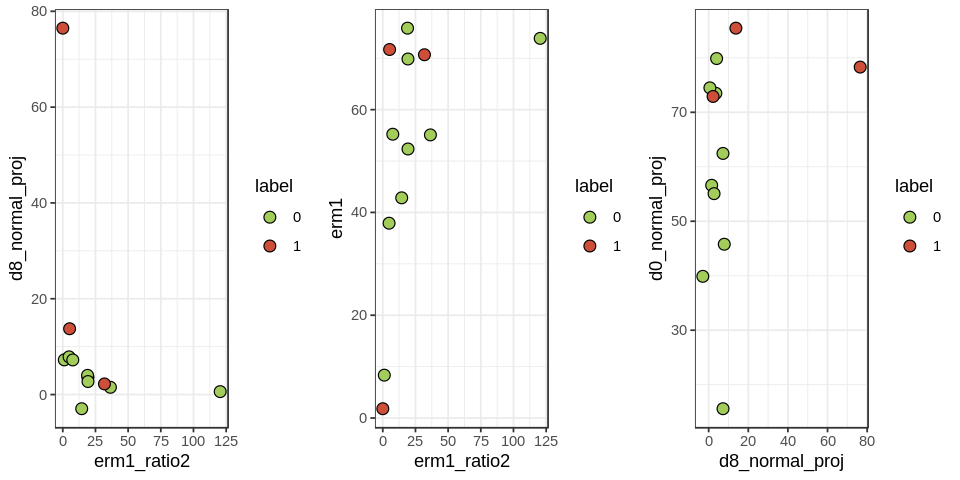

In [257]:
# TO-DO: Return D8-D33 ERM, D33-N distances, D8-N distances
# Plot pair-wise plots of the above
v_hyperdiploid <- list_results[['TEL-AML1']]
v_y <- cbind(
  v_hyperdiploid,
  yeoh_label[rownames(v_hyperdiploid), ]
)

ax1 <- ggplot(v_y, aes(erm1_ratio2, d8_normal_proj, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

ax2 <- ggplot(v_y, aes(erm1_ratio2, erm1, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

ax3 <- ggplot(v_y, aes(d8_normal_proj, d0_normal_proj, fill = label)) +
  geom_point(pch = 21, cex = 3) +
  scale_fill_manual(values = COL_LABEL)

plot_grid(ax1, ax2, ax3, nrow = 1)
# D33-N distances correlated with CD19 expression level of D33?

In [194]:
## M1: Entire data (with Hyperdiploid, Others)
list_feat_boxplots <- lapply(list_results, function(obj) plot_boxplots(obj$X_y))
names(list_feat_boxplots) <- subtypes6

for (subtype in subtypes6) {
  wpath <- sprintf("~/Dropbox/tmp/d0_d33-%s.pdf", subtype)
  ggsave(wpath, list_feat_boxplots[[subtype]],
         width = 7, height = 2.3)
}

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

### Plot boxplots of features

In [26]:
## M1: Entire data (with Hyperdiploid, Others)
boxplots <- lapply(list_obj1, function(obj) plot_boxplots1(obj$X_y))

  label treatment_type             feature    value
1     0            BMT angle_d0d8_d0normal 19.30266
2     0             HR angle_d0d8_d0normal 14.60372
3     0            BMT angle_d0d8_d0normal 40.11626
4     1             HR angle_d0d8_d0normal 28.33446
5     1            BMT angle_d0d8_d0normal 64.26825
6     1             HR angle_d0d8_d0normal 53.41166


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             SR angle_d0d8_d0normal 42.50210
2     0             SR angle_d0d8_d0normal 28.47382
3     0             IR angle_d0d8_d0normal 33.15841
4     1             SR angle_d0d8_d0normal 77.99727
5     0             SR angle_d0d8_d0normal 32.41103
6     0             SR angle_d0d8_d0normal 29.78878
  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 41.73178
2     1             IR angle_d0d8_d0normal 50.76522
3     0             SR angle_d0d8_d0normal 46.81432
4     0             SR angle_d0d8_d0normal 52.80239
5     0             IR angle_d0d8_d0normal 32.49134
6     0             SR angle_d0d8_d0normal 31.99495


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 35.84321
2     1             HR angle_d0d8_d0normal 40.90082
3     1             HR angle_d0d8_d0normal 51.77312
4     1             HR angle_d0d8_d0normal 48.53450
5     0             HR angle_d0d8_d0normal 34.30453
6     1            BMT angle_d0d8_d0normal 37.42251


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 51.72514
2     0             IR angle_d0d8_d0normal 33.58666
3     0             IR angle_d0d8_d0normal 21.11545
4     1             SR angle_d0d8_d0normal 36.43210
5     0             HR angle_d0d8_d0normal 52.41036
6     0             SR angle_d0d8_d0normal 46.95497


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             IR angle_d0d8_d0normal 24.74263
2     0             HR angle_d0d8_d0normal 30.05835
3     0             SR angle_d0d8_d0normal 25.96107
4     1             HR angle_d0d8_d0normal 42.59169
5     0             IR angle_d0d8_d0normal 21.92089
6     0             HR angle_d0d8_d0normal 51.81245


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

  label treatment_type             feature    value
1     0             SR angle_d0d8_d0normal 32.17983
2     0             SR angle_d0d8_d0normal 39.77896
3     0             IR angle_d0d8_d0normal 45.93771
4     0             SR angle_d0d8_d0normal 49.05885
5     0             SR angle_d0d8_d0normal 33.22928
6     0             HR angle_d0d8_d0normal 65.35109


Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”

In [57]:
for (i in seq_len(length(subtypes7))) {
  wpath <- sprintf("~/Dropbox/tmp/_alltrain_wilcox-%s.pdf", subtypes7[i])
  ggsave(wpath, list_feat_boxplots[[i]],
         width = 7, height = 2.3)
}

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

### Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


#### Plot x v.s. TPR

In [ ]:
plot_tpr1 <- function(x, name, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  plot(TPR, sort_x, ylab = name, col = col, type = "l")
}


plot_tpr2 <- function(x, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  lines(TPR, sort_x, col = col, type = "l")
}

cols <- ggplot_palette(4)
features <- c("ERM", "p", "p (w/o MRD)", "-log10(MRD)")

pdf("~/Dropbox/temp/tpr_x.pdf", 6, 6)
plot_tpr1(normaliseMinmax(p_y_sub$erm1), "x", cols[1])
plot_tpr2(p_y_sub$p, cols[2])
plot_tpr2(p_y_sub$p_wo, cols[3])
plot_tpr2(normaliseMinmax(-log10(p_y_sub$d33_mrd)), cols[4])
legend("topleft", legend = features, col = cols, lwd=2)
dev.off()

### Plot odds ratio

In [12]:
plot_odds_ratio <- function(P) {
  COL_LABEL <- c("darkolivegreen3", "tomato3")
  
  odds_prior <- table(P$label)[2] / table(P$label)[1] # rel/rem
  FEATURES <- c("erm1_ratio2", "l2norm_ratio2",
                "mrd", "angle_d0d8_d0normal")
  P_REM <- P[, FEATURES]
  
  compute_odds_ratio <- function(X, odds_prior) {
    (1-X) / (X * odds_prior)
  }

  odds_ratio <- data.matrix(compute_odds_ratio(P_REM, odds_prior))
  odds_ratio[is.infinite(odds_ratio)] <-
    max(odds_ratio[!is.infinite(odds_ratio)]) * 2 # replace with max * 2
  data <- cbind(
    P[, c("pid", "label")],
    odds_ratio
  )

  long_data <- melt(data, id.vars = c("pid", "label"))
  
  ggplot(long_data, aes(x = label, y = value, colour = label)) +
    geom_point(position = position_jitter(height = 0), cex = 3) +
    facet_wrap(~variable, nrow = 1, scales = "free_x") +
    scale_color_manual(values = COL_LABEL)
}

In [520]:
list_odds_ratio <- lapply(list_obj1, function(obj) plot_odds_ratio(obj$P))
for (i in seq_along(list_odds_ratio)) {
  wpath <- sprintf("~/Dropbox/temp/OR-%s.pdf", subtypes[i])
  ggsave(wpath, list_odds_ratio[[i]], width = 8, height = 3)
}

### TODO

- Calculate new features
    - Identify subtypes that did not give good results
- Identify resistance genes (using D33 samples)
- Hyperdiploid - Average chr expression
